# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_090  P16152                          16.499
Sample_022  Q86UN3                          17.902
Sample_063  P40189                          18.335
Sample_002  A6H8L4;E7EUI5;P78536;P78536-2   14.030
Sample_190  A0A087WX80;P24043               16.543
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_023  Q9NZU1           14.494
Sample_196  Q9UHI8           16.330
Sample_025  P98172           15.411
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.266
            A0A075B6Q5                 12.810
            A0A075B6R2                 13.362
            A0A075B6S5                 13.043
            A0A087WSY4                 12.349
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.118
            Q9UI40;Q9UI40-2            12.699
            Q9UIW2                     12.601
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.190
            Q9UP79                     12.132
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.149,15.050,16.842,19.863,15.980,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.701,19.067,...,15.528,15.576,14.511,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.625,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.729,17.705,17.039,14.964,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.405,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.885,15.345,17.084,18.708,14.249,19.433,11.760,11.215
Sample_207,15.739,16.877,15.469,16.898,14.923,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.266,...,16.012,15.178,12.779,15.050,16.842,19.863,12.554,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.005,19.067,16.188,...,15.528,15.576,12.765,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.805,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.176,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.272,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.896,15.345,17.084,18.708,14.249,19.433,12.238,12.597
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 282.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.27it/s]

100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.48it/s]

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.01it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  1.88it/s]

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.95it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.82it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.86it/s]

100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.93it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.70it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.31it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.07it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.42it/s]

100%|██████████| 7/7 [00:02<00:00,  1.96it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.60it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.69it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.19it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.68it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.48it/s]

100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

100%|██████████| 8/8 [00:02<00:00,  3.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.11it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.82it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.35it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.80it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.45it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.29it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.18it/s]

100%|██████████| 9/9 [00:02<00:00,  2.87it/s]

100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.35it/s]

 30%|███       | 3/10 [00:00<00:01,  3.88it/s]

 40%|████      | 4/10 [00:01<00:01,  3.64it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.51it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.28it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.87it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.85it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.25it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.85it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.93it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.63it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.32it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.25it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.24it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.21it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.25it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.26it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.49it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.98it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.67it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.56it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.75it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.72it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.77it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.75it/s]

100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

100%|██████████| 12/12 [00:03<00:00,  3.89it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.51it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.23it/s]

 31%|███       | 4/13 [00:00<00:02,  3.71it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.53it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.39it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.82it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.83it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.96it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.04it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.14it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.14it/s]

100%|██████████| 13/13 [00:03<00:00,  3.18it/s]

100%|██████████| 13/13 [00:03<00:00,  3.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.87it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.70it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.01it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.45it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.42it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.41it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.28it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.36it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.48it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.33it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.65it/s]

100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.69it/s]

 20%|██        | 3/15 [00:00<00:03,  3.54it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.39it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.12it/s]

 40%|████      | 6/15 [00:01<00:02,  3.15it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.00it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.94it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.89it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.92it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.88it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.96it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.074 0.037          0.694 0.405       0.103   
2             0.005 0.003      0.059 0.019          0.707 0.085       0.599   
3             0.005 0.003      0.070 0.029          0.689 0.101       0.597   
4             0.004 0.002      0.052 0.011          0.764 0.106       0.610   
5             0.005 0.003      0.055 0.018          0.706 0.084       0.660   
6             0.005 0.003      0.061 0.020          0.770 0.084       0.810   
7             0.006 0.004      0.066 0.023          0.776 0.080       0.810   
8             0.006 0.005      0.064 0.025          0.770 0.084       0.798   
9             0.005 0.005      0.053 0.017          0.777 0.078       0.810   
10            0.005 0.004      0.054 0.026          0.781 0.079       0.814   
11            0.004 0.003      0.038 0.012          0.787 0.082       0.796   
12            0.005 0.003      0.045 0.008          0.812 0.077       0.803   
13            0.004 0.000      0.046 0.011          0.833 0.079       0.812   
14            0.003 0.001      0.037 0.009          0.834 0.078       0.816   
15            0.005 0.004      0.054 0.020          0.814 0.078       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.172 0.134                  0.544 0.042        0.844   
2          0.102   0.643 0.078                  0.707 0.057        0.776   
3          0.111   0.633 0.085                  0.697 0.063        0.764   
4          0.119   0.671 0.094                  0.733 0.067        0.787   
5          0.110   0.677 0.077                  0.728 0.060        0.792   
6          0.118   0.784 0.079                  0.815 0.068        0.884   
7          0.108   0.788 0.074                  0.819 0.064        0.884   
8          0.112   0.779 0.076                  0.811 0.064        0.885   
9          0.108   0.790 0.075                  0.820 0.065        0.893   
10         0.103   0.793 0.071                  0.823 0.061        0.893   
11         0.102   0.788 0.074                  0.819 0.064        0.893   
12         0.102   0.803 0.072                  0.833 0.060        0.903   
13         0.100   0.818 0.069                  0.845 0.057        0.909   
14         0.097   0.821 0.066                  0.847 0.055        0.908   
15         0.090   0.807 0.066                  0.835 0.056        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.813 0.084        210.000 0.000  
2          0.067                  0.752 0.083        210.000 0.000  
3          0.071                  0.738 0.088        210.000 0.000  
4          0.067                  0.750 0.082        210.000 0.000  
5          0.064                  0.756 0.079        210.000 0.000  
6          0.049                  0.853 0.061        210.000 0.000  
7          0.050                  0.851 0.061        210.000 0.000  
8          0.050                  0.856 0.059        210.000 0.000  
9          0.050                  0.876 0.052        210.000 0.000  
10         0.050                  0.877 0.051        210.000 0.000  
11         0.050                  0.875 0.053        210.000 0.000  
12         0.048                  0.891 0.046        210.000 0.000  
13         0.050                  0.896 0.049        210.000 0.000  
14         0.050                  0.895 0.047        210.000 0.000  
15         0.047                  0.895 0.045 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 436.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.21it/s]

100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.43it/s]

100%|██████████| 4/4 [00:00<00:00,  3.68it/s]

100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.38it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.07it/s]

100%|██████████| 5/5 [00:00<00:00,  6.58it/s]

100%|██████████| 5/5 [00:00<00:00,  7.03it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.35it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.12it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.69it/s]

100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.30it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.16it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.70it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.34it/s]

100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

100%|██████████| 7/7 [00:01<00:00,  6.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.39it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.14it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.63it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.33it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.06it/s]

100%|██████████| 8/8 [00:01<00:00,  5.90it/s]

100%|██████████| 8/8 [00:01<00:00,  6.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.56it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.06it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.57it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.25it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.97it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.84it/s]

100%|██████████| 9/9 [00:01<00:00,  5.80it/s]

100%|██████████| 9/9 [00:01<00:00,  6.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 11.31it/s]

 40%|████      | 4/10 [00:00<00:00,  7.07it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.55it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.26it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.05it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.93it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.82it/s]

100%|██████████| 10/10 [00:01<00:00,  5.79it/s]

100%|██████████| 10/10 [00:01<00:00,  6.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.24it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.03it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.56it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.20it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.04it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.92it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.83it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.73it/s]

100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

100%|██████████| 11/11 [00:01<00:00,  6.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.17it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.21it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.74it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.36it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.09it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.92it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.81it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.77it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.71it/s]

100%|██████████| 12/12 [00:01<00:00,  5.71it/s]

100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.27it/s]

 31%|███       | 4/13 [00:00<00:01,  7.13it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.65it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.33it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.14it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.95it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.87it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.80it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.77it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.74it/s]

100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.41it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.14it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.59it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.31it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.08it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.97it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.88it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.83it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.73it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.73it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.67it/s]

100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

100%|██████████| 14/14 [00:02<00:00,  6.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.42it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.14it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.60it/s]

 40%|████      | 6/15 [00:00<00:01,  6.30it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.10it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.97it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.87it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.76it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.69it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.63it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.66it/s]

100%|██████████| 15/15 [00:02<00:00,  5.67it/s]

100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.042 0.016          0.000 0.000       0.000   
2             0.002 0.000      0.029 0.004          0.677 0.114       0.451   
3             0.002 0.000      0.027 0.002          0.777 0.090       0.688   
4             0.002 0.000      0.027 0.003          0.775 0.091       0.673   
5             0.002 0.000      0.026 0.000          0.754 0.094       0.666   
6             0.002 0.000      0.027 0.000          0.742 0.098       0.684   
7             0.002 0.000      0.026 0.000          0.753 0.088       0.718   
8             0.002 0.000      0.027 0.000          0.755 0.089       0.724   
9             0.002 0.000      0.026 0.000          0.737 0.096       0.729   
10            0.002 0.000      0.027 0.000          0.770 0.091       0.753   
11            0.002 0.000      0.026 0.000          0.824 0.087       0.790   
12            0.002 0.000      0.027 0.000          0.820 0.086       0.790   
13            0.002 0.000      0.027 0.000          0.817 0.085       0.777   
14            0.002 0.000      0.026 0.000          0.812 0.083       0.784   
15            0.002 0.000      0.027 0.000          0.809 0.087       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.859   
2          0.122   0.532 0.106                  0.645 0.061        0.695   
3          0.115   0.724 0.090                  0.771 0.068        0.870   
4          0.105   0.715 0.079                  0.763 0.060        0.866   
5          0.104   0.702 0.080                  0.751 0.061        0.862   
6          0.120   0.706 0.091                  0.754 0.070        0.865   
7          0.117   0.730 0.084                  0.772 0.067        0.866   
8          0.114   0.734 0.081                  0.775 0.065        0.865   
9          0.119   0.728 0.091                  0.769 0.074        0.873   
10         0.117   0.755 0.081                  0.793 0.065        0.900   
11         0.099   0.803 0.074                  0.832 0.061        0.923   
12         0.102   0.800 0.071                  0.830 0.059        0.922   
13         0.111   0.790 0.073                  0.823 0.059        0.925   
14         0.114   0.792 0.075                  0.824 0.061        0.925   
15         0.105   0.792 0.072                  0.823 0.059        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.831 0.087        210.000 0.000  
2          0.082                  0.665 0.085        210.000 0.000  
3          0.056                  0.844 0.074        210.000 0.000  
4          0.054                  0.843 0.068        210.000 0.000  
5          0.053                  0.838 0.066        210.000 0.000  
6          0.054                  0.838 0.065        210.000 0.000  
7          0.053                  0.831 0.069        210.000 0.000  
8          0.053                  0.832 0.068        210.000 0.000  
9          0.058                  0.841 0.071        210.000 0.000  
10         0.050                  0.878 0.061        210.000 0.000  
11         0.045                  0.912 0.051        210.000 0.000  
12         0.043                  0.911 0.050        210.000 0.000  
13         0.042                  0.913 0.047        210.000 0.000  
14         0.042                  0.910 0.046        210.000 0.000  
15         0.043                  0.908 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1467.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 54.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 42.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 37.48it/s]

100%|██████████| 4/4 [00:00<00:00, 37.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 37.21it/s]

100%|██████████| 5/5 [00:00<00:00, 34.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 37.84it/s]

100%|██████████| 6/6 [00:00<00:00, 33.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 37.02it/s]

100%|██████████| 7/7 [00:00<00:00, 32.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 36.83it/s]

100%|██████████| 8/8 [00:00<00:00, 31.64it/s]

100%|██████████| 8/8 [00:00<00:00, 32.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 37.35it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 31.37it/s]

100%|██████████| 9/9 [00:00<00:00, 31.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 37.94it/s]

 80%|████████  | 8/10 [00:00<00:00, 31.67it/s]

100%|██████████| 10/10 [00:00<00:00, 31.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 37.66it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.07it/s]

100%|██████████| 11/11 [00:00<00:00, 30.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 37.55it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 30.29it/s]

100%|██████████| 12/12 [00:00<00:00, 29.10it/s]

100%|██████████| 12/12 [00:00<00:00, 29.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 35.51it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 29.50it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 28.71it/s]

100%|██████████| 13/13 [00:00<00:00, 29.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 36.81it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 30.93it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 29.42it/s]

100%|██████████| 14/14 [00:00<00:00, 29.91it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 37.23it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.81it/s]

 80%|████████  | 12/15 [00:00<00:00, 28.66it/s]

100%|██████████| 15/15 [00:00<00:00, 28.31it/s]

100%|██████████| 15/15 [00:00<00:00, 29.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.026 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.026 0.000          0.304 0.447       0.023   
3             0.002 0.000      0.026 0.000          0.548 0.336       0.099   
4             0.002 0.000      0.026 0.000          0.538 0.333       0.104   
5             0.002 0.000      0.027 0.003          0.688 0.088       0.566   
6             0.002 0.000      0.026 0.000          0.704 0.096       0.640   
7             0.002 0.000      0.026 0.000          0.705 0.094       0.646   
8             0.002 0.000      0.026 0.000          0.705 0.097       0.661   
9             0.002 0.000      0.026 0.000          0.694 0.097       0.652   
10            0.002 0.000      0.027 0.000          0.683 0.099       0.635   
11            0.002 0.000      0.026 0.000          0.691 0.091       0.662   
12            0.002 0.000      0.027 0.000          0.689 0.088       0.665   
13            0.002 0.000      0.027 0.000          0.691 0.089       0.669   
14            0.002 0.000      0.026 0.000          0.682 0.092       0.641   
15            0.002 0.000      0.026 0.000          0.677 0.095       0.646   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.712   
2          0.033   0.042 0.060                  0.507 0.021        0.570   
3          0.065   0.161 0.102                  0.521 0.042        0.551   
4          0.070   0.168 0.107                  0.520 0.046        0.530   
5          0.103   0.616 0.079                  0.688 0.058        0.771   
6          0.115   0.665 0.089                  0.720 0.069        0.809   
7          0.115   0.668 0.086                  0.722 0.066        0.808   
8          0.129   0.674 0.094                  0.727 0.073        0.808   
9          0.129   0.665 0.093                  0.718 0.072        0.803   
10         0.120   0.652 0.097                  0.708 0.074        0.810   
11         0.134   0.669 0.095                  0.722 0.074        0.811   
12         0.127   0.671 0.093                  0.722 0.070        0.810   
13         0.131   0.673 0.096                  0.724 0.072        0.808   
14         0.121   0.655 0.092                  0.710 0.070        0.804   
15         0.130   0.655 0.099                  0.710 0.072        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.674 0.072        210.000 0.000  
2          0.119                  0.563 0.110        210.000 0.000  
3          0.090                  0.517 0.078        210.000 0.000  
4          0.080                  0.505 0.077        210.000 0.000  
5          0.060                  0.710 0.072        210.000 0.000  
6          0.066                  0.761 0.080        210.000 0.000  
7          0.068                  0.758 0.082        210.000 0.000  
8          0.066                  0.749 0.082        210.000 0.000  
9          0.067                  0.747 0.080        210.000 0.000  
10         0.063                  0.750 0.079        210.000 0.000  
11         0.060                  0.753 0.076        210.000 0.000  
12         0.061                  0.753 0.080        210.000 0.000  
13         0.063                  0.750 0.082        210.000 0.000  
14         0.063                  0.741 0.083        210.000 0.000  
15         0.062                  0.735 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,1,15
score_time,1,1,5
test_precision,14,11,7
test_recall,14,12,13
test_f1,14,11,8
test_balanced_accuracy,14,11,8
test_roc_auc,13,14,11
test_average_precision,13,13,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.47it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.19it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.64it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.14it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.97it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.92it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.85it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.86it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.78it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.71it/s]

100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

100%|██████████| 14/14 [00:02<00:00,  6.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 38.00it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 31.35it/s]

100%|██████████| 11/11 [00:00<00:00, 30.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.87it/s]

 31%|███       | 4/13 [00:00<00:01,  8.21it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.56it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.18it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.93it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.77it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.75it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.62it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.67it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.56it/s]

100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

100%|██████████| 13/13 [00:01<00:00,  7.01it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


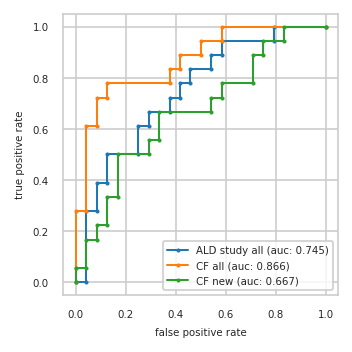

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.278  0.000 0.278  0.042 0.056
3          0.083 0.278  0.042 0.278  0.042 0.167
4          0.083 0.389  0.042 0.611  0.083 0.167
5          0.125 0.389  0.083 0.611  0.083 0.222
6          0.125 0.500  0.083 0.722  0.125 0.222
7          0.250 0.500  0.125 0.722  0.125 0.333
8          0.250 0.611  0.125 0.778  0.167 0.333
9          0.292 0.611  0.375 0.778  0.167 0.500
10         0.292 0.667  0.375 0.833  0.292 0.500
11         0.375 0.667  0.417 0.833  0.292 0.556
12         0.375 0.722  0.417 0.889  0.333 0.556
13         0.417 0.722  0.500 0.889  0.333 0.667
14         0.417 0.778  0.500 0.944  0.542 0.667
15         0.458 0.778  0.583 0.944  0.542 0.722
16         0.458 0.833  0.583 1.000  0.583 0.722
17         0.542 0.833  1.000 1.000  0.583 0.778
18         0.542 0.889    NaN   NaN  0.708 0.778
19         0.583 0.889    NaN   NaN  0.708 0.889
20         0.583 0.944    NaN   NaN  0.750 0.889
21         0.792 0.944    NaN   NaN  0.750 0.944
22         0.792 1.000    NaN   NaN  0.833 0.944
23         1.000 1.000    NaN   NaN  0.833 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q07507,Q9NS84,P05997
2,Q9NRN5,Q9UBR2,Q9UI40;Q9UI40-2
3,P61981,P61981,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,Q9Y2T3;Q9Y2T3-3,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
5,Q99983,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P10636-2;P10636-6,P14174,P31321
7,P14174,A0A0C4DGY8;D6RA00;Q9UHY7,Q96GD0
8,P00338;P00338-3,P25189;P25189-2,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


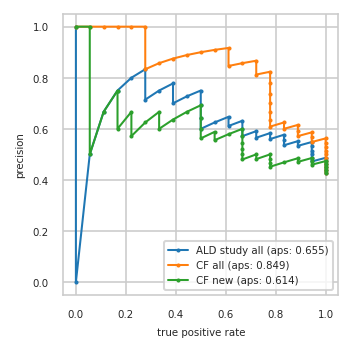

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.548 0.944     0.452 0.778
12         0.533 0.889     0.567 0.944     0.467 0.778
13         0.552 0.889     0.586 0.944     0.483 0.778
14         0.536 0.833     0.571 0.889     0.500 0.778
15         0.556 0.833     0.593 0.889     0.481 0.722
16         0.577 0.833     0.615 0.889     0.500 0.722
17         0.560 0.778     0.600 0.833     0.480 0.667
18         0.583 0.778     0.625 0.833     0.500 0.667
19         0.565 0.722     0.609 0.778     0.522 0.667
20         0.591 0.722     0.636 0.778     0.545 0.667
21         0.571 0.667     0.667 0.778     0.571 0.667
22         0.600 0.667     0.700 0.778     0.600 0.667
23         0.632 0.667     0.737 0.778     0.579 0.611
24         0.611 0.611     0.778 0.778     0.556 0.556
25         0.647 0.611     0.824 0.778     0.588 0.556
26         0.625 0.556     0.812 0.722     0.562 0.500
27         0.600 0.500     0.867 0.722     0.600 0.500
28         0.643 0.500     0.857 0.667     0.643 0.500
29         0.692 0.500     0.846 0.611     0.692 0.500
30         0.750 0.500     0.917 0.611     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.667 0.333
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.714 0.278     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


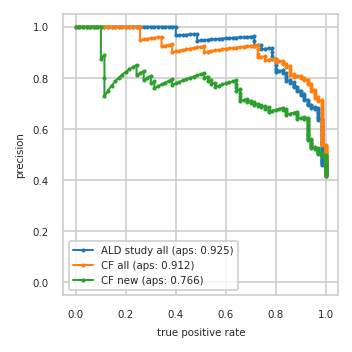

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


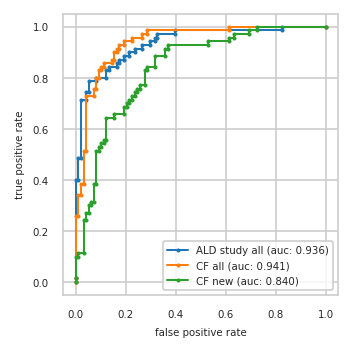

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}